In [1]:
pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 33.9 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import mahotas
from IPython.display import Image


# Reads the image index number as input and returns its object


In [3]:
from google.colab import drive
drive.mount('/content/drive')
filepath = "/content/drive/MyDrive/InformationRetrieval/Img"

Mounted at /content/drive


In [4]:
def read_image(num_img: int) -> np.ndarray:
    path = f'{filepath}/image_name{num_img}.jpg'
    if os.path.exists(path):
        return cv2.imread(path)
    return None

# Displays the image passed as input and waits the window to be closed

In [5]:
def display_image(img: np.ndarray) -> None:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
    cv2.imshow("Result", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Gets the image object as input, treats it and returns a list of arrays which are histogram values for each of the three color channels

In [6]:
def rgb_histogram(image: np.ndarray, white_pixels: int) -> list:
    channels = cv2.split(image) # splits image in three color channels (rgb)
    list_rgb = []
    colors = ('r', 'g', 'b')
    for channel in channels:
        histogram = cv2.calcHist([channel], [0], None, [256], [0, 256]) # Calculates histogram values for channel given
        histogram[255]= histogram[255]-white_pixels # Removes white pixels from histogram values regarding background
        #eq_histogram = equalize_histogram(histogram)
        #list_rgb.append(eq_histogram)
        list_rgb.append(histogram) # Appends histogram channel to list containing all rgb ones
    return list_rgb # Returns list containing rgb channels

# Shows histogram of rgb channels with a matplotlib plot with three channels overlapped

In [7]:
def plot_hist(rgb_list: list) -> None:
    colors = ('r', 'g', 'b')
    for channel, color in zip(rgb_list, colors):
        plt.plot(channel, color)
    plt.xlabel('Intensity')
    plt.ylabel('Pixel Number')
    plt.title('RGB Color Histogram')
    plt.legend(['Red', 'Green', 'Blue'])
    plt.show()

# Equalize histogram given

In [8]:
def equalize_histogram(histogram: np.ndarray) -> np.ndarray:
    gray_hist = np.sum(histogram, axis=1)
    gray_hist = gray_hist.astype(np.uint8)
    equalized_gray_hist = cv2.equalizeHist(gray_hist)
    equalized_gray_hist = equalized_gray_hist.astype(np.uint8)
    equalized_hist = np.zeros_like(histogram)
    equalized_hist[:, :] = equalized_gray_hist
    print(type(equalized_hist))
    return equalized_hist

# Given an image object, returns the number of white pixels in it, useful to detect background size

In [9]:
def get_white_pixels(image: np.ndarray) -> int:
    num_white_pixels = np.count_nonzero(np.all(image == [255, 255, 255], axis=-1))
    return num_white_pixels

# Calculate haralick texture features

In [10]:
def haralick_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = mahotas.features.haralick(gray).mean(axis=0)
    return np.array(features)


# Loads all images in dataset until end_num index and adds their data to main dictionary

In [11]:
def load_imgs() -> None:
    for num_img in range(end_num+1): # Creates main loop
        img1 = read_image(num_img) # Reads image with num_img index
        if img1 is not None: # Cheks if not null
            rgb_list = rgb_histogram(img1, white_pixels) # Gets rgb color histograms for img given
            histogram_dict[num_img] = rgb_list # Adds rgb histogram values arrays to 'Histogram' entry in main dictionary
            texture_dict[num_img] = haralick_features(img1)
        if num_img%100 == 0:
          print(num_img)

# Compares all images in main dictionary with image in selected_num_img and returns dictionary with similarity values

In [12]:
def compare_imgs(selected_num_img: int, comparing_dict: dict, histogram_dict: dict, texture_dict: dict) -> dict:
    sel_hist_list = histogram_dict[selected_num_img] # Gets histogram value from base image
    sel_texture = texture_dict[selected_num_img] # Gets texture haralick value from base image
    #del histogram_dict[selected_num_img] # Deletes entry from base image in main dictionary
    #del texture_dict[selected_num_img] # Deletes entry from base image in main dictionary
    texture_dict = normalize_texture_dict(texture_dict, sel_texture)
    for key in histogram_dict.keys(): # For each key in dictionary
        comparing_dict[key] = get_comp_value(sel_hist_list, sel_texture, key, histogram_dict, texture_dict) # Gets similarity value and adds it to similarity dictionary
    comparing_dict = dict(sorted(comparing_dict.items(), key = lambda x: x[1], reverse=True)) # Sorts dictionary by similarity
    del comparing_dict[selected_num_img]
    return comparing_dict

# Gets similarity value between base image and key image

In [13]:
def get_comp_value(sel_hist_list: list, sel_texture, key: int, histogram_dict: dict, texture_dict: dict) -> float:
    hist1 = np.array([sel_hist_list])
    hist2 = np.array([histogram_dict[key]])
    correlation = np.corrcoef(hist1.flatten(), hist2.flatten())[0, 1] # Calculates correlation between two histograms

    #return correlation*0.9+texture_dict[key]*0.1
    return correlation

# Normalizing texture euclidean distance

In [14]:
def normalize_texture_dict(texture_dict: dict, sel_texture: np.ndarray) -> dict:
    for key in texture_dict.keys():
      texture_dict[key] = np.linalg.norm(sel_texture-texture_dict[key])
    texture_array = np.array(list(texture_dict.values()))
    min_val = np.min(texture_array)
    max_val = np.max(texture_array)
    norm_array = (texture_array-min_val)/(max_val-min_val)
    norm_dict = dict(zip(texture_dict.keys(), norm_array))
    return norm_dict


# Displays num_top_values images (most similar)

In [15]:
def get_top_values(num_top_values: int) -> None:
    print("Model Image: Img N.", selected_img)
    display(Image(filename=f'{filepath}/image_name{selected_img}.jpg', width=200, height=200))
    list_top = list(ordered_dict.keys())[:num_top_values]
    print()
    print("-"*20)
    print()
    for img_num in list_top:
      print()
      print("Img N.", img_num)
      display(Image(filename=f'{filepath}/image_name{img_num}.jpg', width=200, height=200))

# Main dictionary with img data

In [16]:
histogram_dict = {}
texture_dict = {}

# Last index number of images in memory

In [17]:
end_num = 1484

In [ ]:
white_img = read_image(1373) # Creates image array of background removal model image

In [ ]:
white_pixels = int(0.9*get_white_pixels(white_img)) # Gets white pixels number from white_img
load_imgs() # Loads all images data in main dictionary

In [ ]:
selected_img = 116 # Image kits needes to be similar to
comparing_dict = {} # Comparing dictionary with similarity values
ordered_dict = compare_imgs(selected_img, comparing_dict, histogram_dict, texture_dict) # Compares all images and gets similarity values in dictionary in order

Model Image: Img N. 116


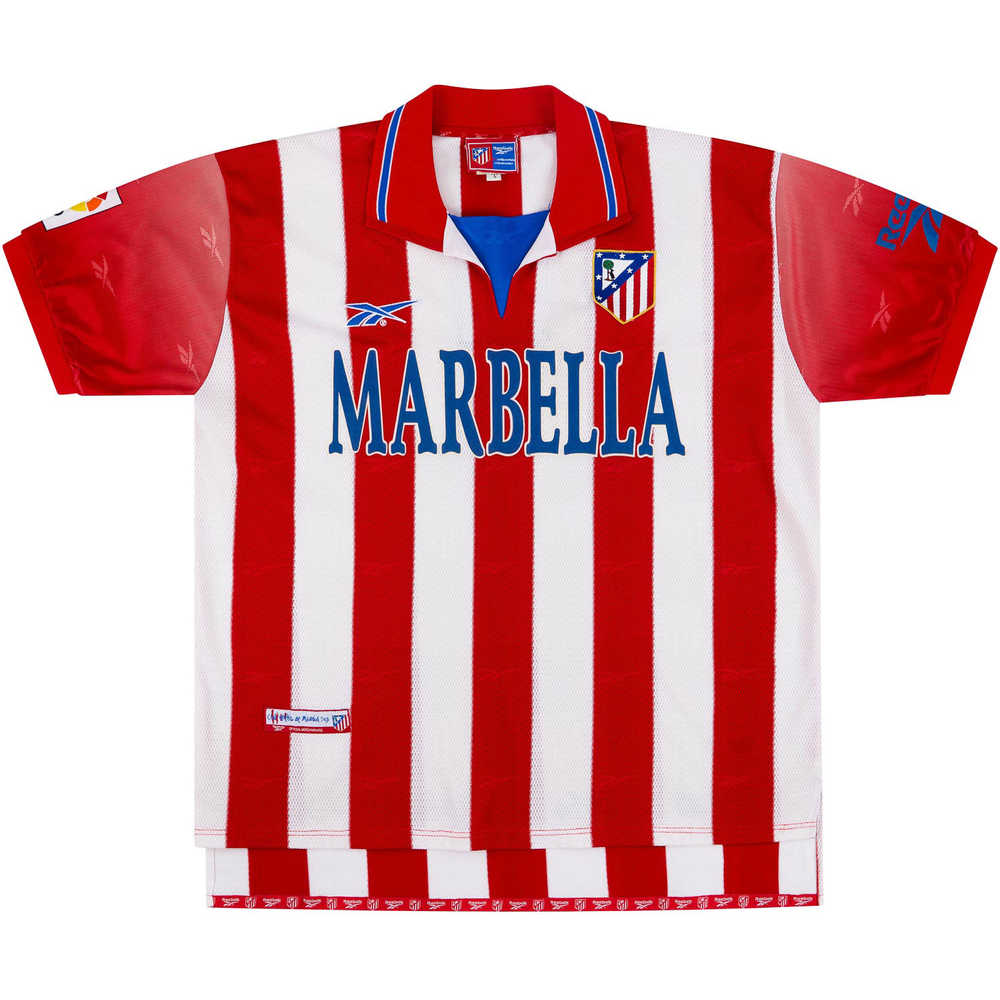


--------------------


Img N. 557


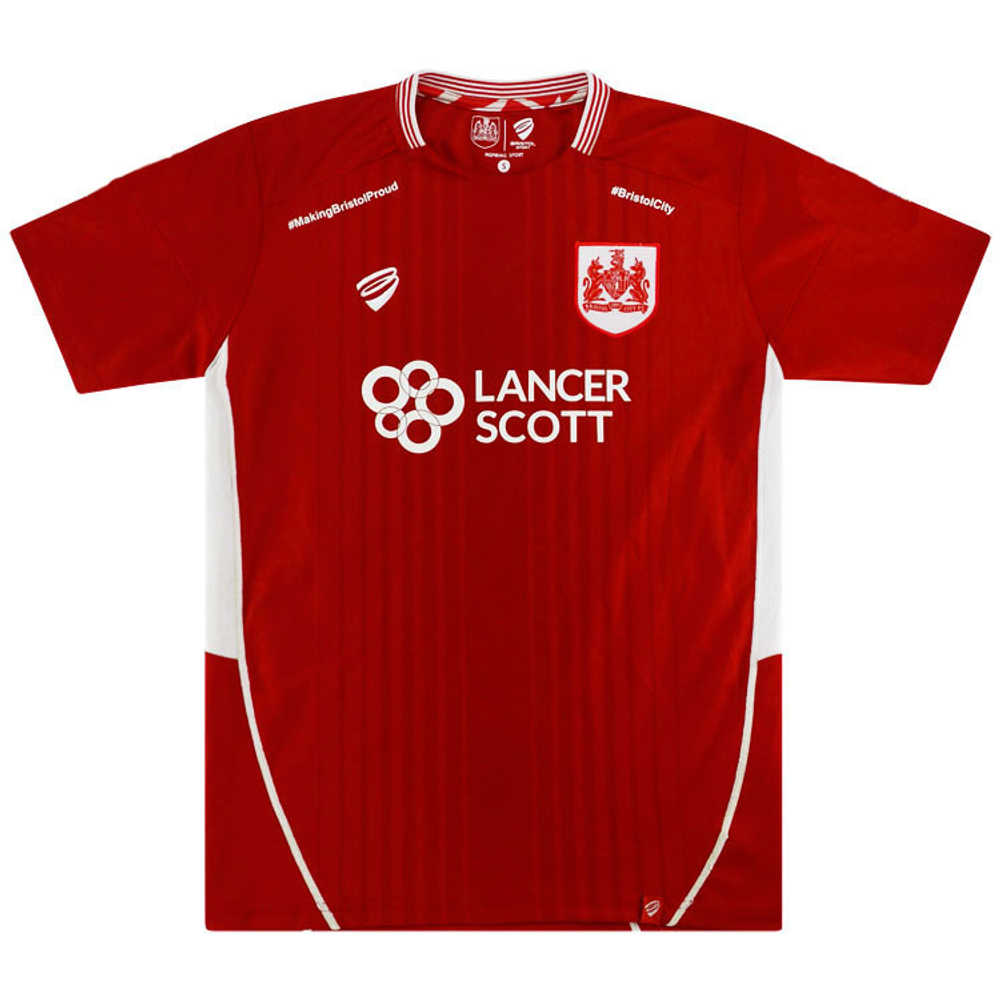


Img N. 47


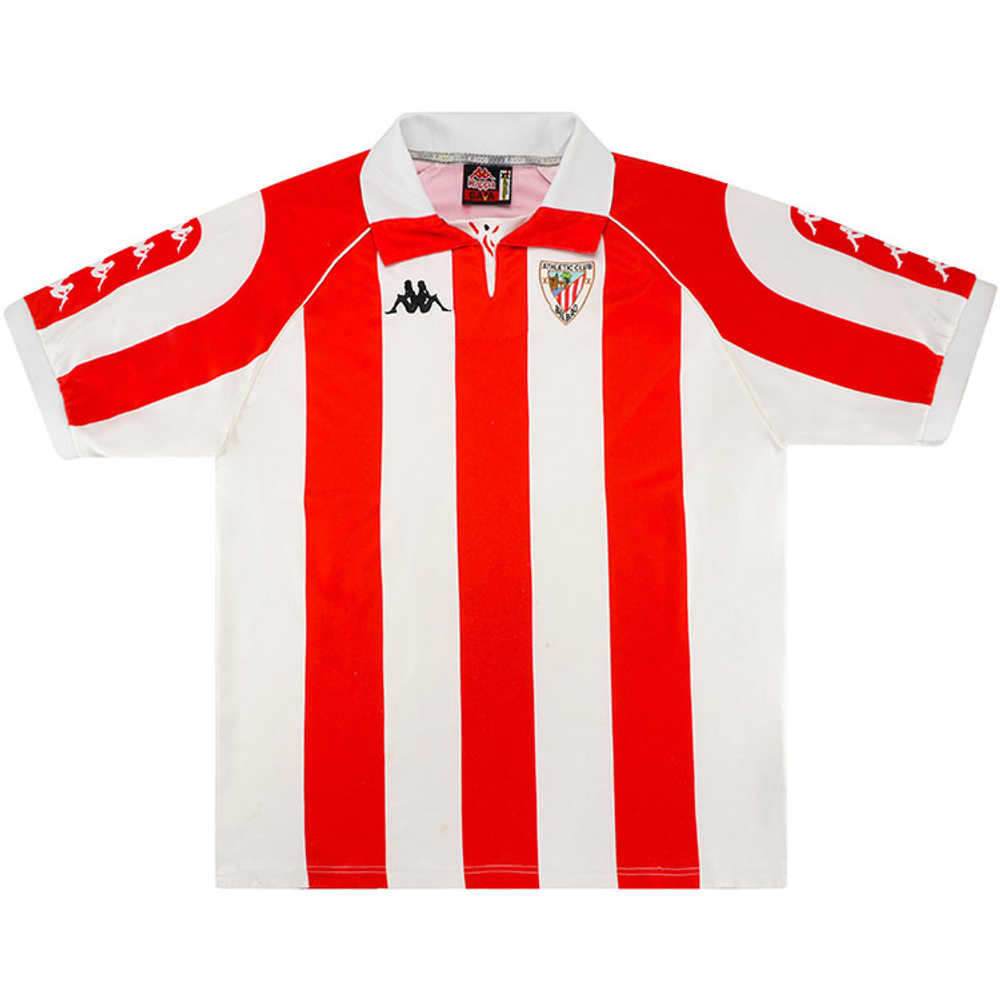


Img N. 87


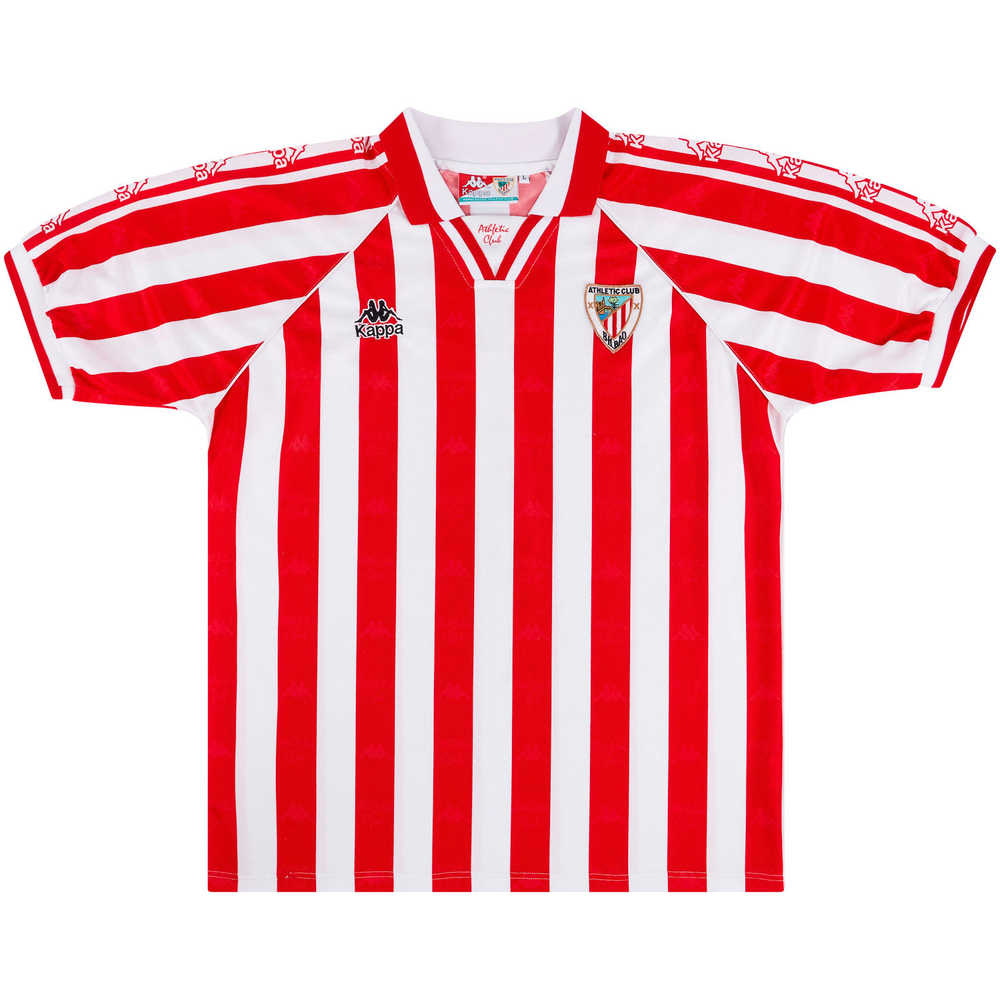


Img N. 761


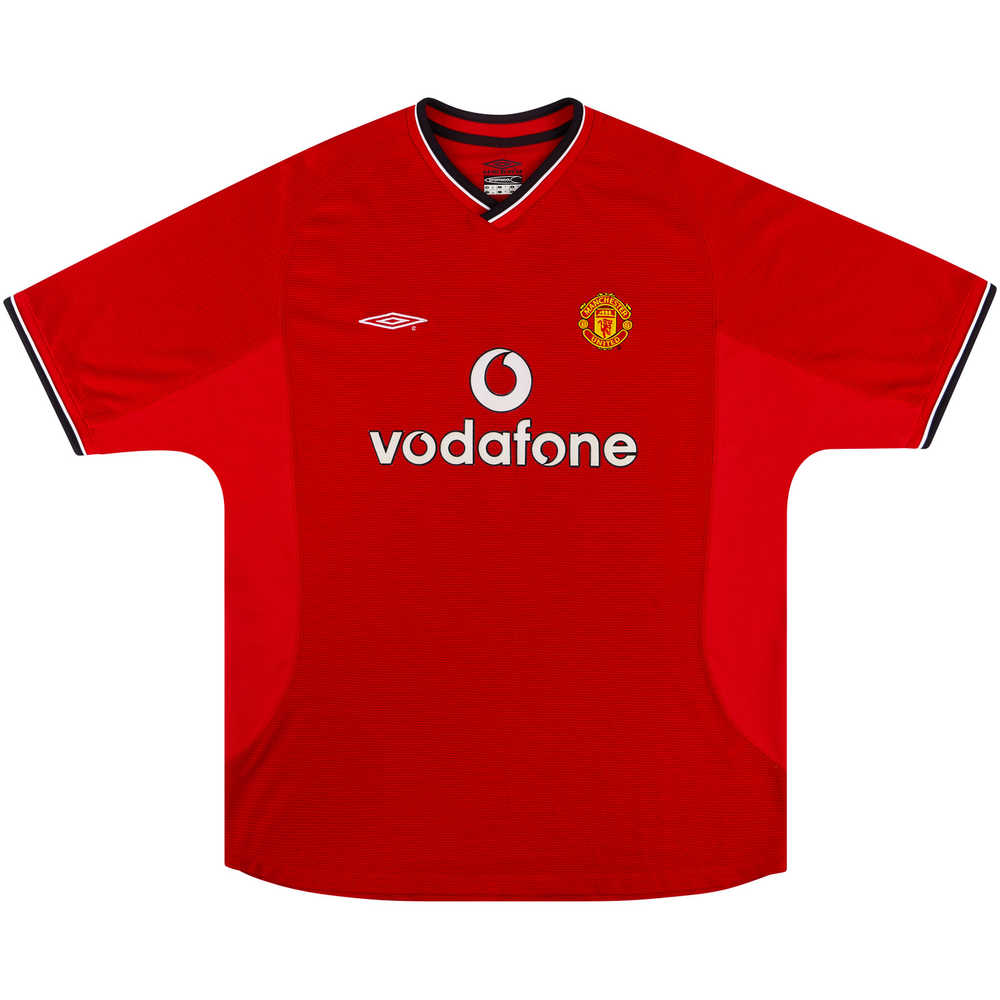


Img N. 763


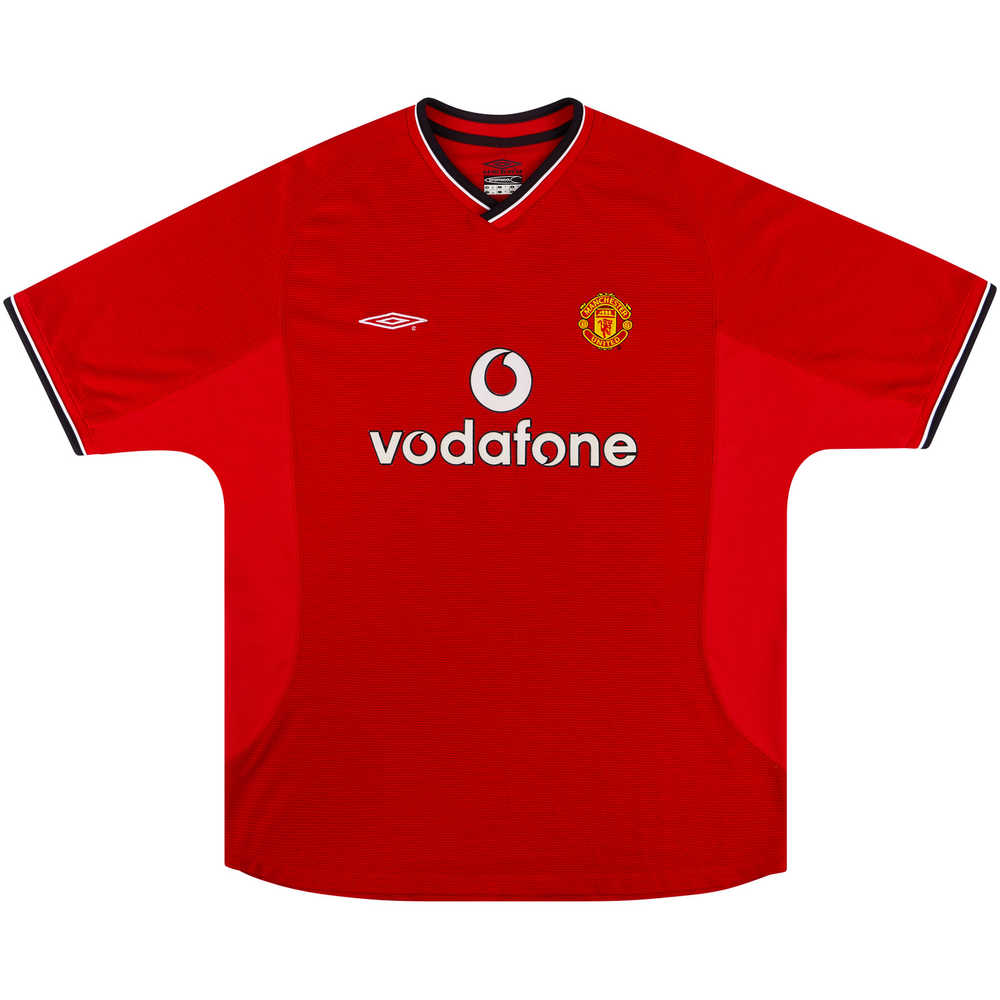


Img N. 765


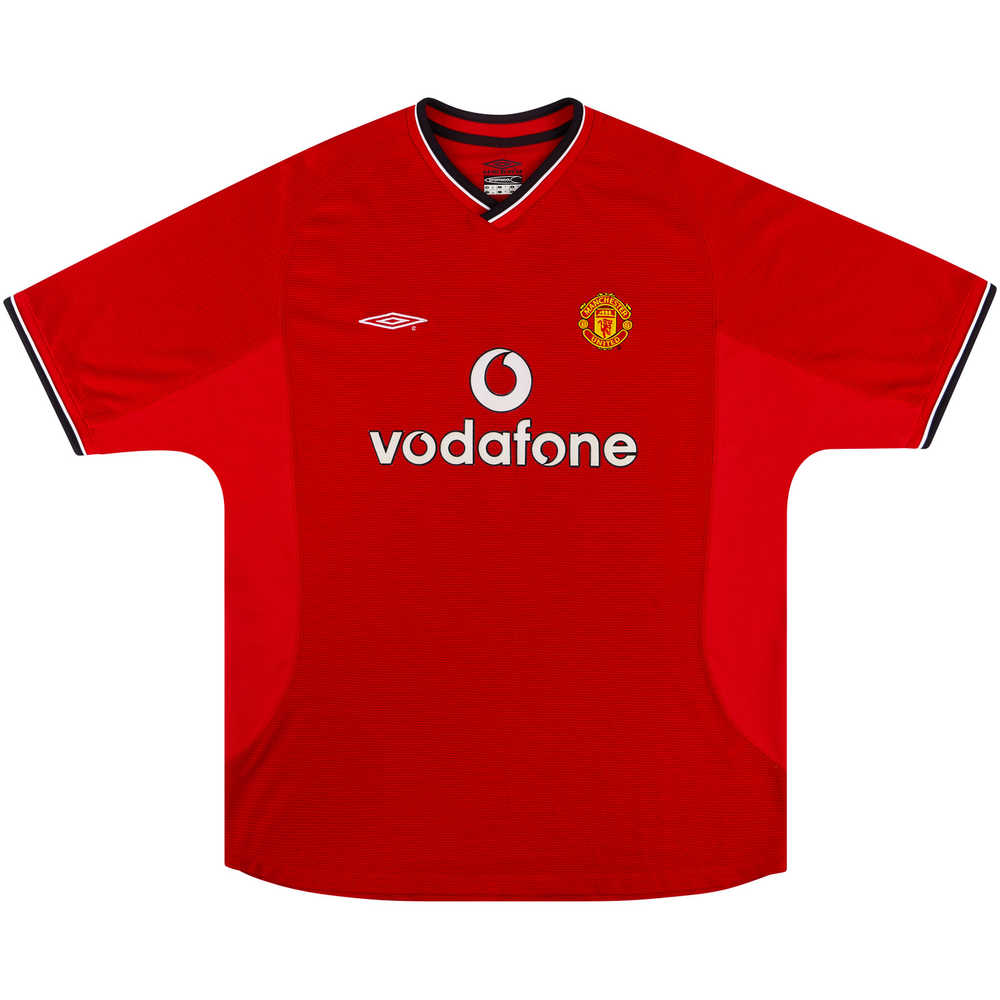


Img N. 766


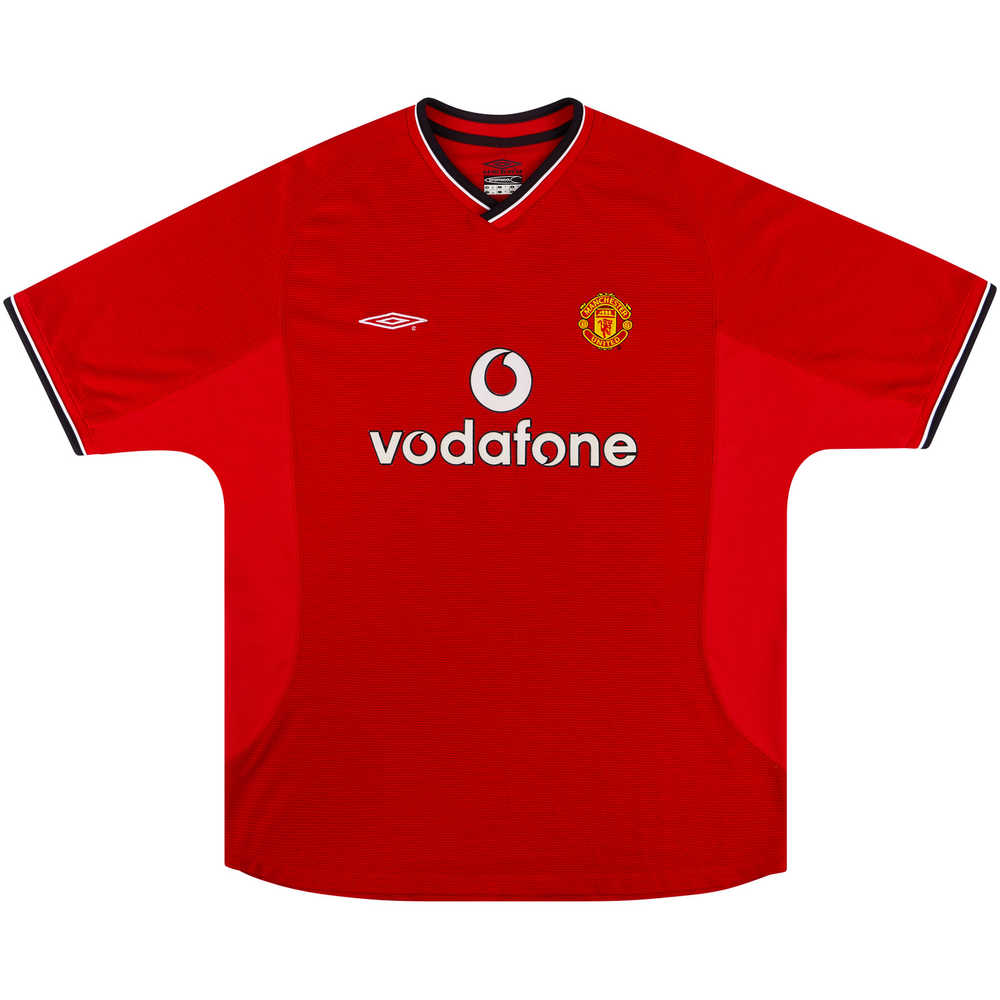


Img N. 771


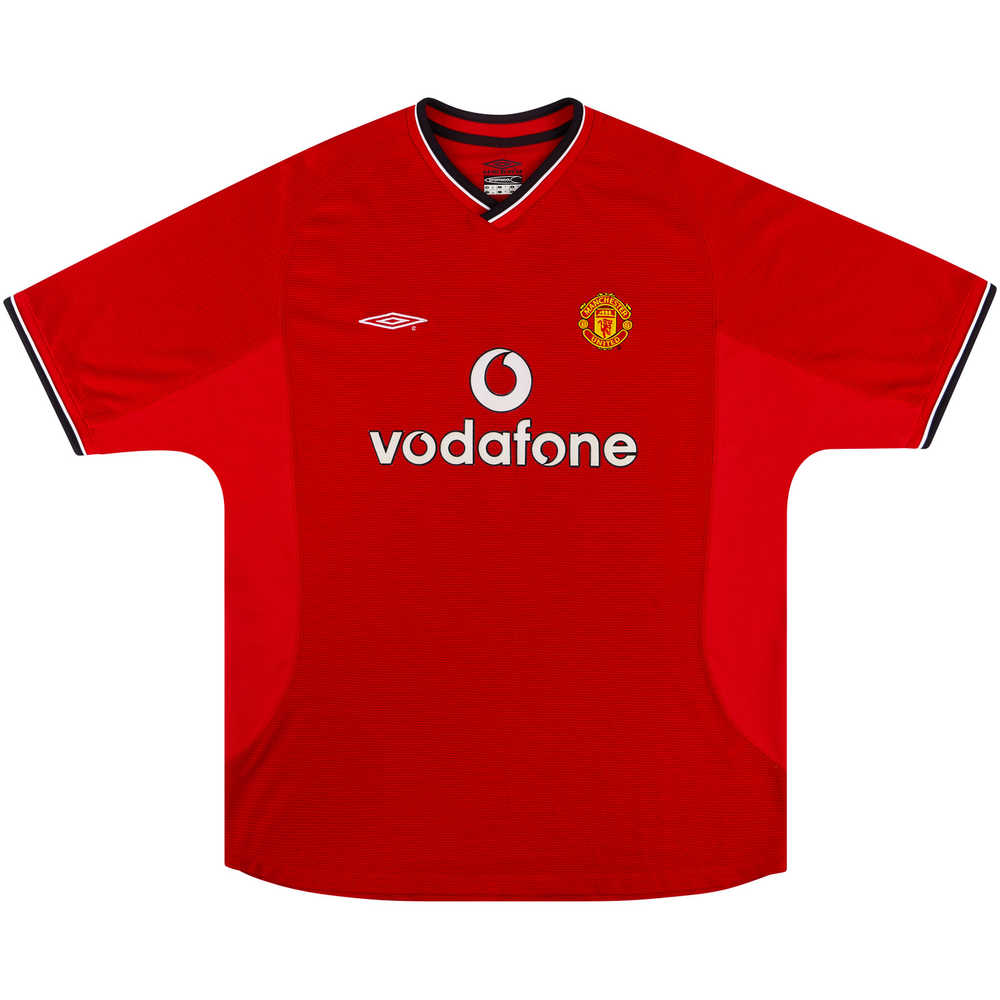


Img N. 1076


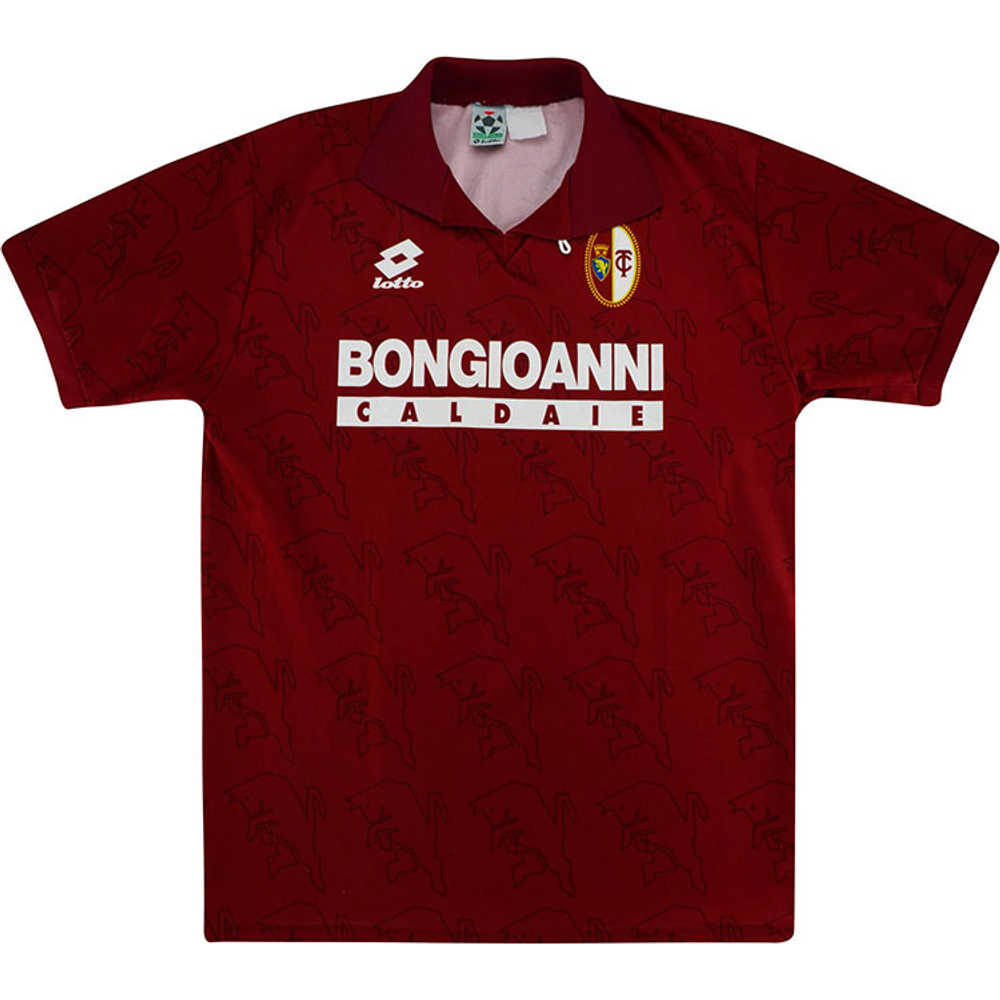


Img N. 762


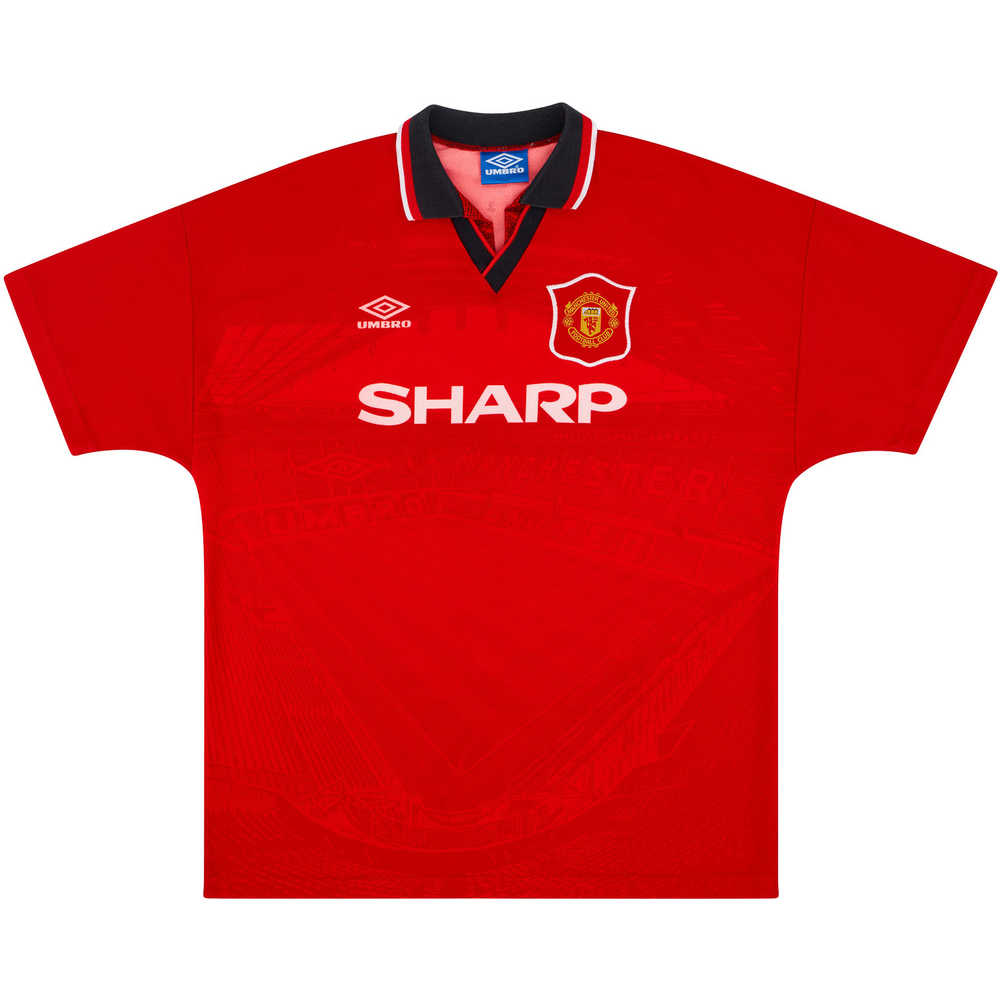


Img N. 555


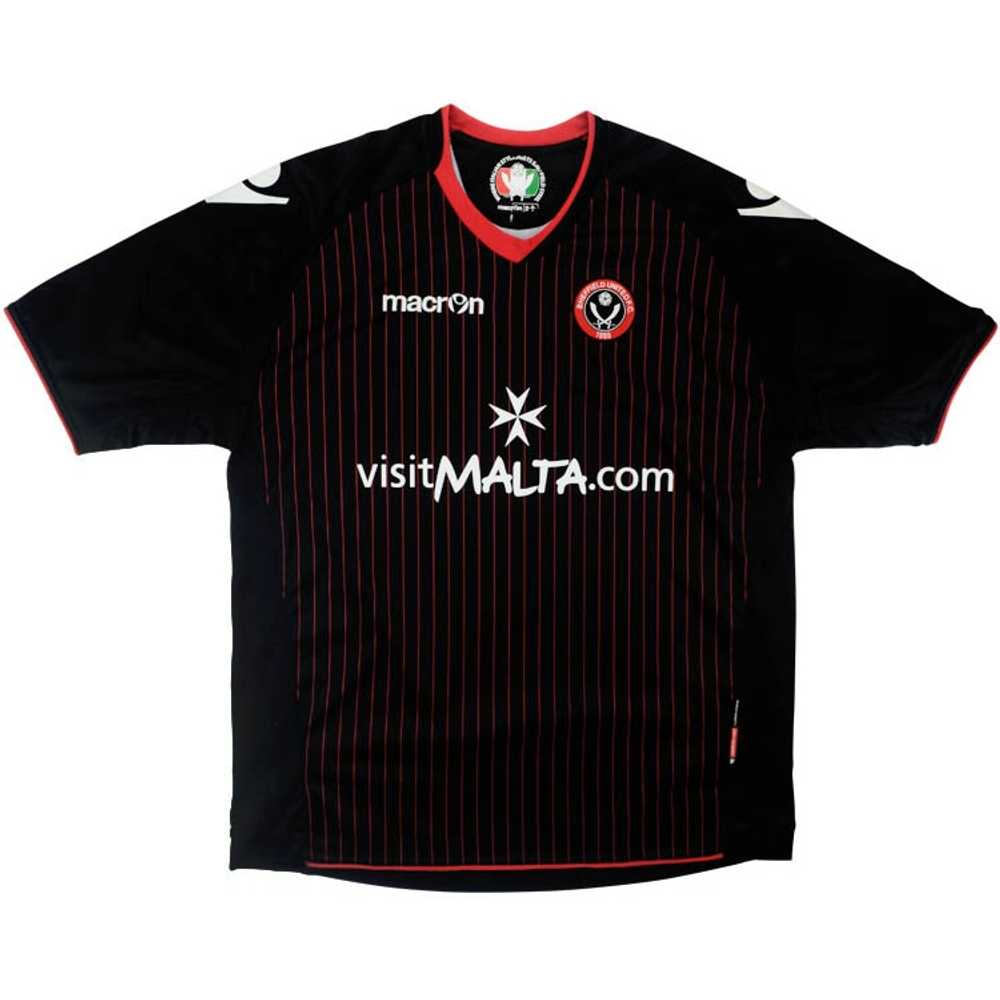


Img N. 1325


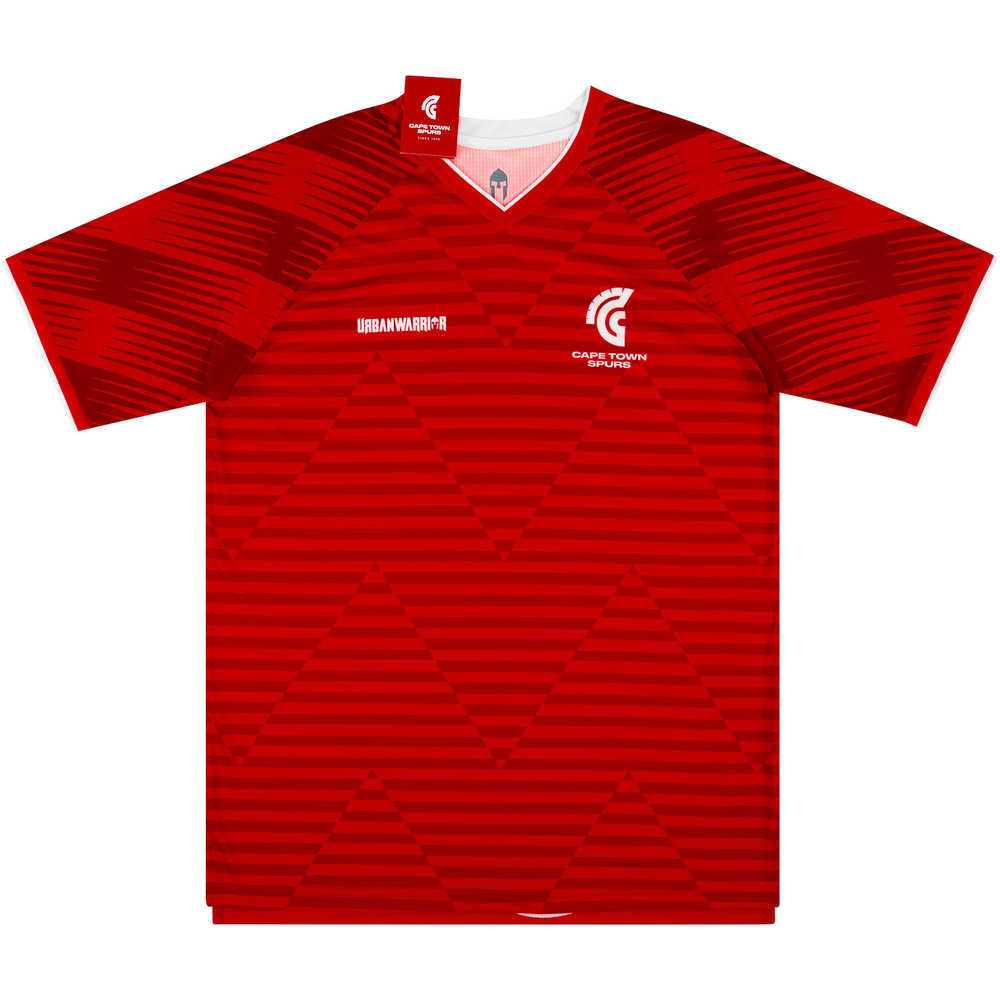


Img N. 1181


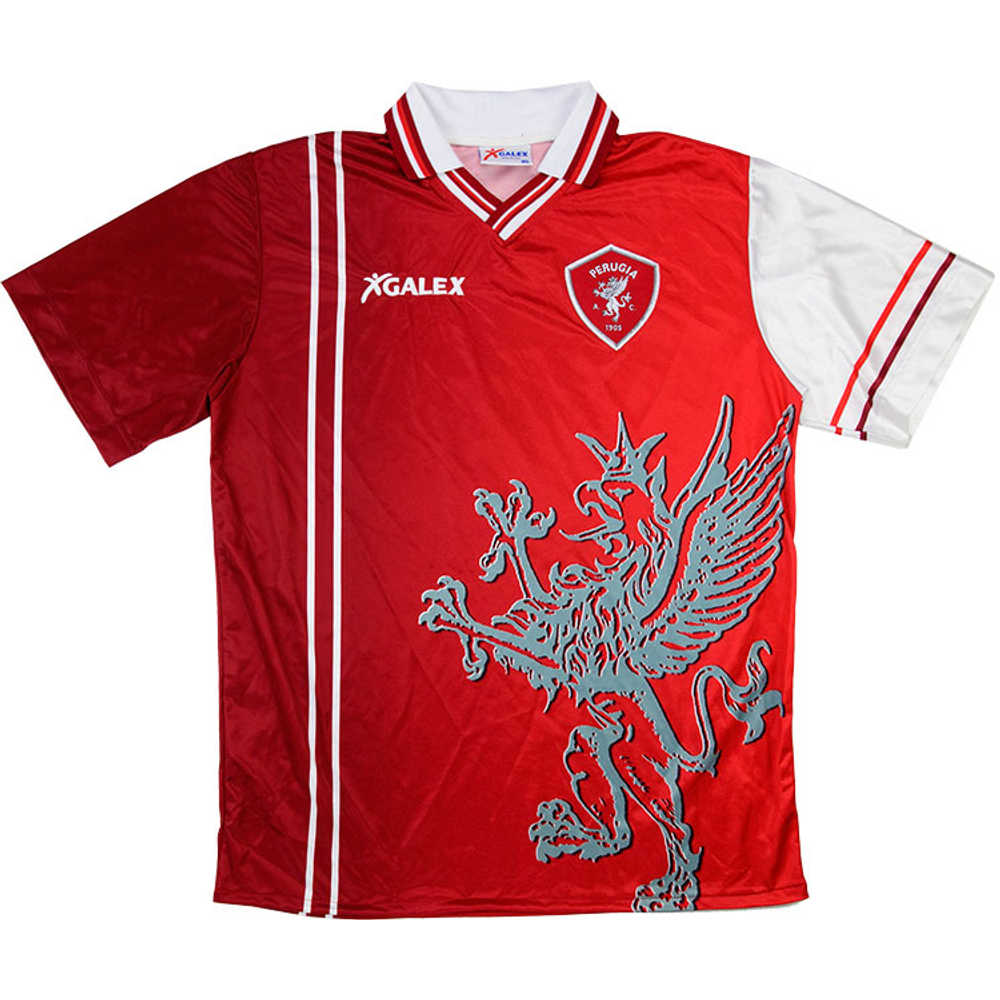


Img N. 4


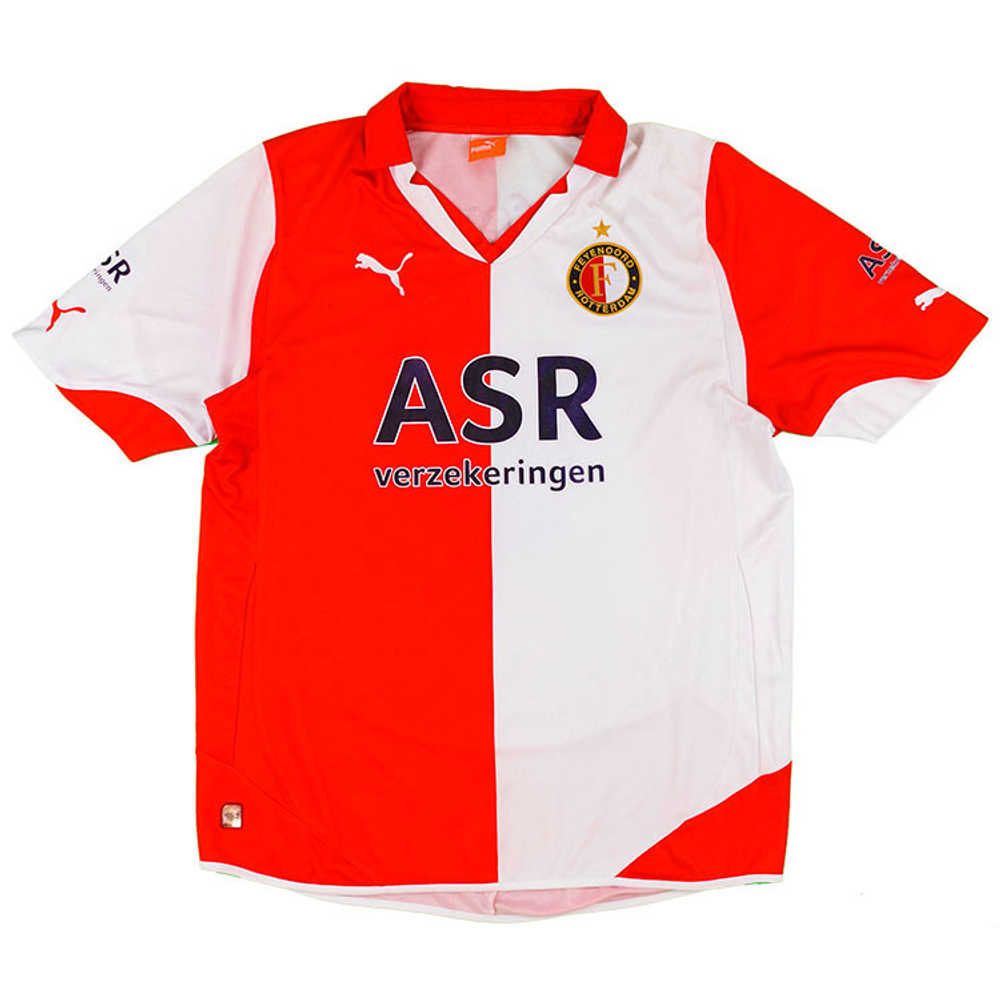


Img N. 929


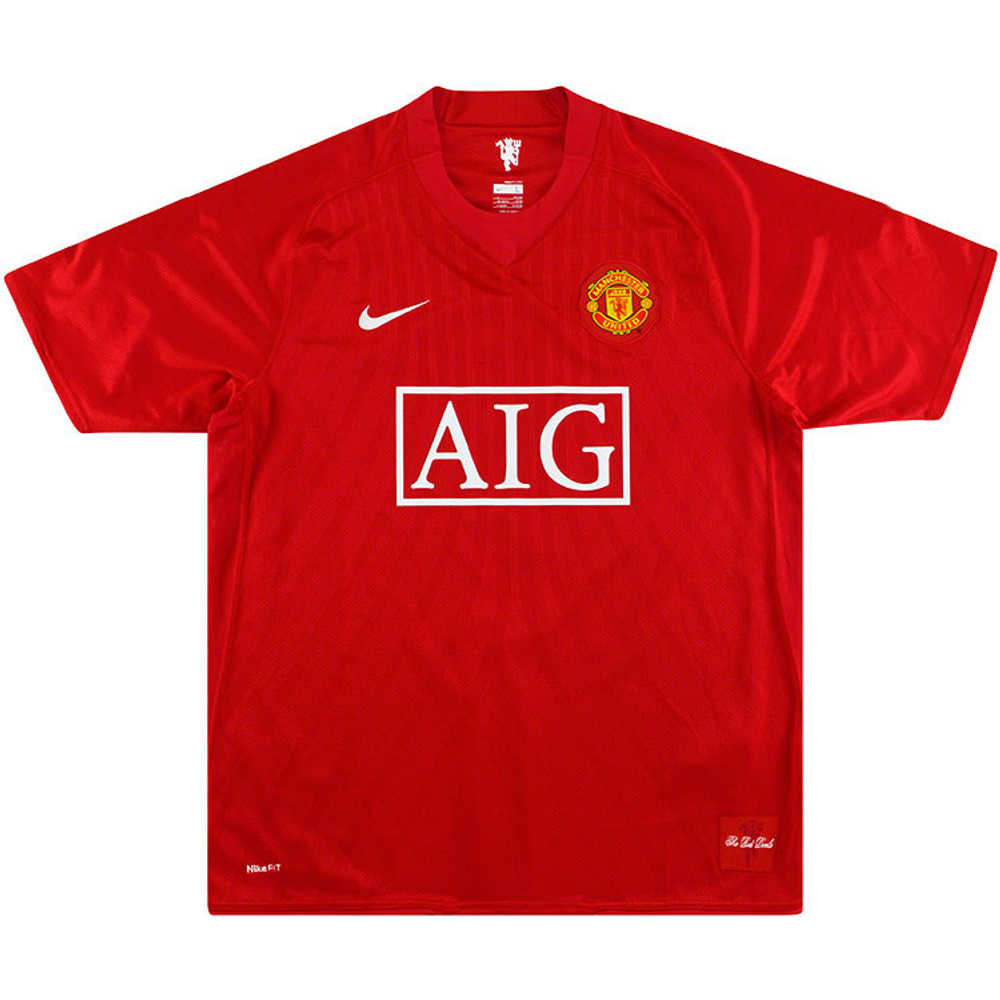

In [ ]:
get_top_values(15) # Get top values